In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM,Dense
from keras.models import load_model
sns.set(rc={'figure.figsize':(16, 8)})

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarn

In [2]:
df = pd.read_csv("data.csv")

In [3]:
# this channels do not in test file so, we do not need them
df = df[(df["Station"]!='PYC Online Stream Fr CBC-9+') & (df["Station"]!='PYC Online Stream Fr CBC-8+')]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 614832 entries, 0 to 616655
Data columns (total 20 columns):
Unnamed: 0                                614832 non-null int64
Episode                                   614832 non-null object
Station                                   614832 non-null object
Channel Type                              614832 non-null object
Season                                    614832 non-null object
Year                                      614832 non-null int64
Date                                      614832 non-null object
Day of week                               614832 non-null object
Start_time                                614789 non-null object
End_time                                  614789 non-null object
Length                                    614832 non-null int64
Name of show                              614832 non-null object
Name of episode                           394077 non-null object
Genre                                     61483

In [5]:
df.nunique()

Unnamed: 0                                614832
Episode                                     6668
Station                                       22
Channel Type                                   2
Season                                         4
Year                                           4
Date                                         877
Day of week                                    7
Start_time                                138321
End_time                                  138333
Length                                        39
Name of show                                6668
Name of episode                            86556
Genre                                         27
First time or rerun                            2
# of episode in the season                     2
Movie?                                         2
Game of the Canadiens during episode?          2
Market Share_total                           545
Temperature in Montreal during episode     11828
dtype: int64

In [7]:
df["Date"] = df["Date"].astype("datetime64[ns]")
df["Start_time"] = df["Start_time"].astype("datetime64[ns]")
df["End_time"] = df["End_time"].astype("datetime64[ns]")


df["Movie?"] = pd.get_dummies(df["Movie?"])
df["First time or rerun"] = pd.get_dummies(df["First time or rerun"])
df["# of episode in the season"] = pd.get_dummies(df["# of episode in the season"])
df["Game of the Canadiens during episode?"] = pd.get_dummies(df["Game of the Canadiens during episode?"])
df["Movie?"] = pd.get_dummies(df["Movie?"])
df['Channel Type'] = pd.get_dummies(df['Channel Type'])
df.head()

,Unnamed: 0,Episode,Station,Channel Type,Season,Year,Date,Day of week,Start_time,End_time,Length,Name of show,Name of episode,Genre,First time or rerun,# of episode in the season,Movie?,Game of the Canadiens during episode?,Market Share_total,Temperature in Montreal during episode
0,1,Vidéoclips V,V Total,0,Fall,2016,2016-08-29,Monday,2016-08-29 06:00:00,2016-08-29 08:00:00,8,Vidéoclips V,NaN,Music Video Clips,0,1,0,0,0.9,20.400
1,2,Apollo dans l'frigo,V Total,0,Fall,2016,2016-08-29,Monday,2016-08-29 08:00:00,2016-08-29 08:30:00,2,Apollo dans l'frigo,NaN,Informal Education and Recreation and Leisure,0,1,0,0,0.5,19.125
2,3,Infopublicité,V Total,0,Fall,2016,2016-08-29,Monday,2016-08-29 08:30:00,2016-08-29 09:00:00,2,Infopublicité,NaN,"Infomercials, Promotional and Corporate Videos",0,1,0,0,0.3,19.125
3,4,"Infos, Les",V Total,0,Fall,2016,2016-08-29,Monday,2016-08-29 09:00:00,2016-08-29 10:00:00,4,"Infos, Les",NaN,News,0,1,0,0,1.7,18.125
4,5,"Souper presque parfait, Un",V Total,0,Fall,2016,2016-08-29,Monday,2016-08-29 10:00:00,2016-08-29 10:30:00,2,"Souper presque parfait, Un",NaN,Reality Programs,0,1,0,0,2.2,18.250


In [8]:
df.corr()["Market Share_total"]

Unnamed: 0                               -0.016994
Channel Type                             -0.572567
Year                                     -0.017873
Length                                    0.008387
First time or rerun                       0.002033
# of episode in the season                0.056849
Movie?                                    0.025550
Game of the Canadiens during episode?    -0.004321
Market Share_total                        1.000000
Temperature in Montreal during episode    0.007354
Name: Market Share_total, dtype: float64

In [ ]:
# Temperature & Game of the Canadiens during episode? 
# First time or rerun & irst time or rerun ***have low correlation so i drop them at the first step

In [9]:
df.drop(["Unnamed: 0","Episode","Year",'Day of week',"Name of show","Name of episode","Temperature in Montreal during episode",'# of episode in the season', 'Genre', 'First time or rerun','Movie?','Game of the Canadiens during episode?'],axis=1,inplace=True)


In [10]:
df.head()

,Station,Channel Type,Season,Date,Start_time,End_time,Length,Market Share_total
0,V Total,0,Fall,2016-08-29,2016-08-29 06:00:00,2016-08-29 08:00:00,8,0.9
1,V Total,0,Fall,2016-08-29,2016-08-29 08:00:00,2016-08-29 08:30:00,2,0.5
2,V Total,0,Fall,2016-08-29,2016-08-29 08:30:00,2016-08-29 09:00:00,2,0.3
3,V Total,0,Fall,2016-08-29,2016-08-29 09:00:00,2016-08-29 10:00:00,4,1.7
4,V Total,0,Fall,2016-08-29,2016-08-29 10:00:00,2016-08-29 10:30:00,2,2.2


In [11]:
# see overall behaivor in days and weeks(in average)
def report_DW(df ,station,strat_T, end_T):
    temp_df = df[df["Station"]==station]
    s = strat_T
    e = end_T
    temp_df.set_index(temp_df["Date"], drop=True ,inplace=True)
    temp_df.sort_index(inplace=True)
    total_daily_mean = temp_df.loc[s:e, "Market Share_total"].resample('D').mean()
    total_weekly_mean = temp_df.loc[s:e, "Market Share_total"].resample('W').mean()
    
    
    fig, ax = plt.subplots(figsize=(16,8))
    ax.set_title(f"Mean-Market Share of  '{station}' Station ")
    ax.plot(total_daily_mean,
    marker='.', linestyle='-', linewidth=0.4, label='Daily Mean Resample')
    
    #===================================================================================#
    
    ax.plot(total_weekly_mean,
    marker='o', linewidth=2, markersize=8, linestyle='-', label='Weekly Mean Resample')
    ax.set_ylabel('Market Share')
    ax.legend();

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/home/mobin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == '':


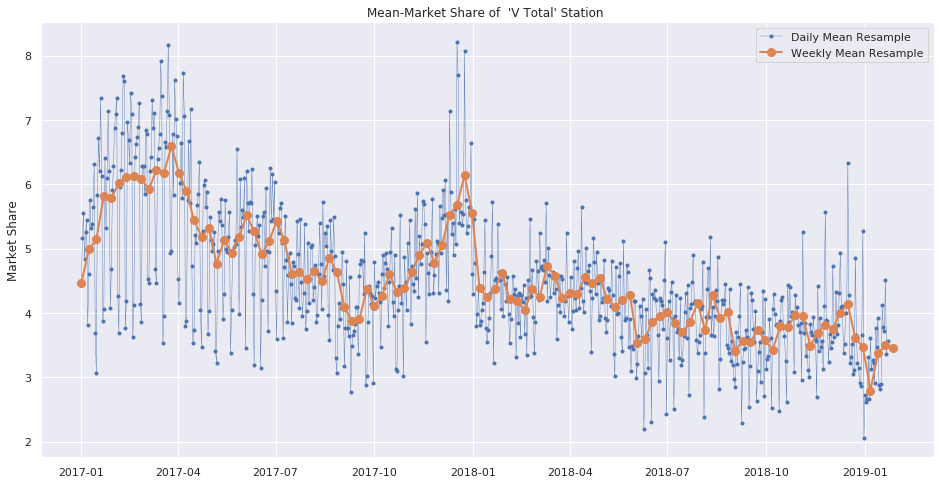

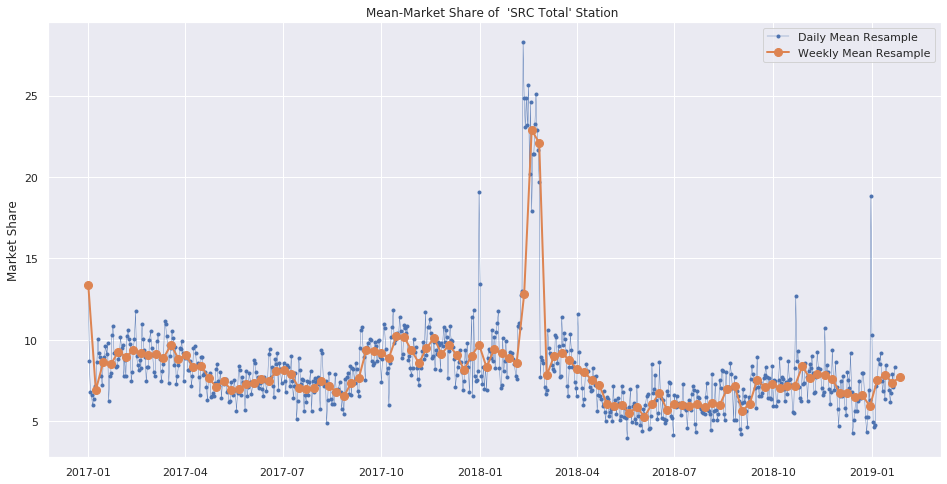

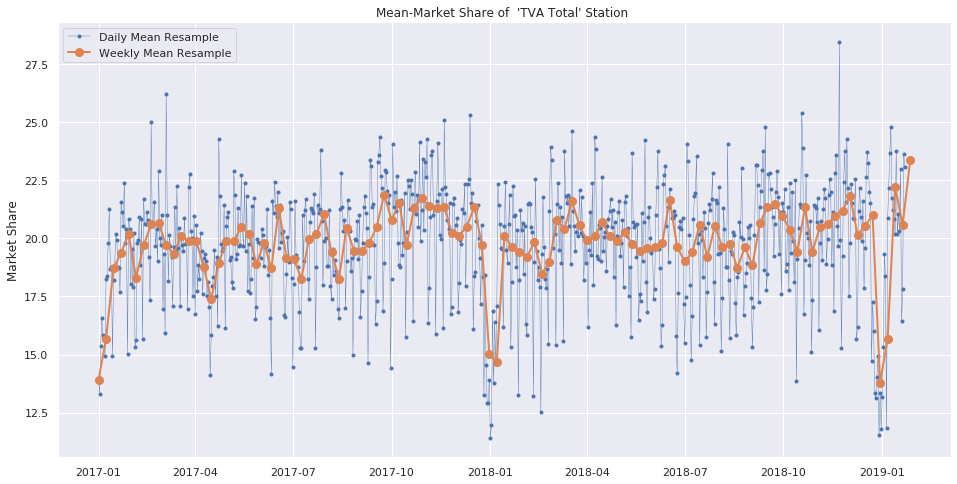

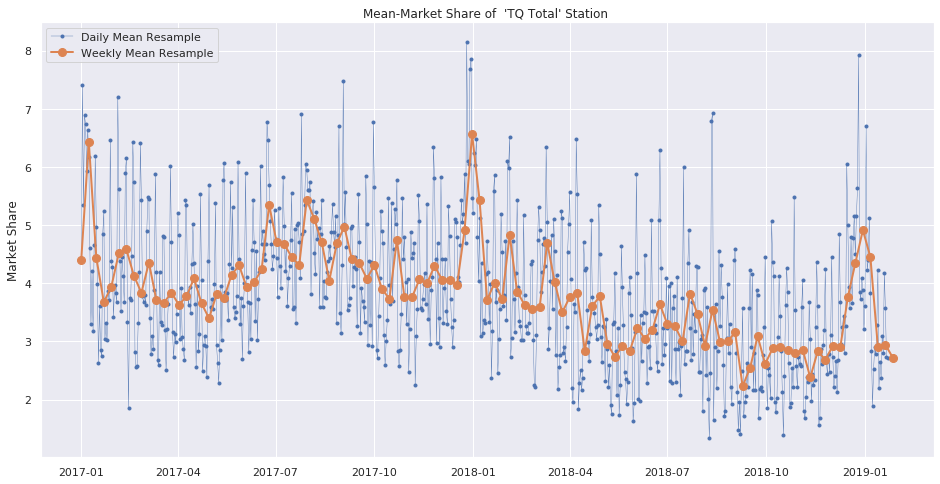

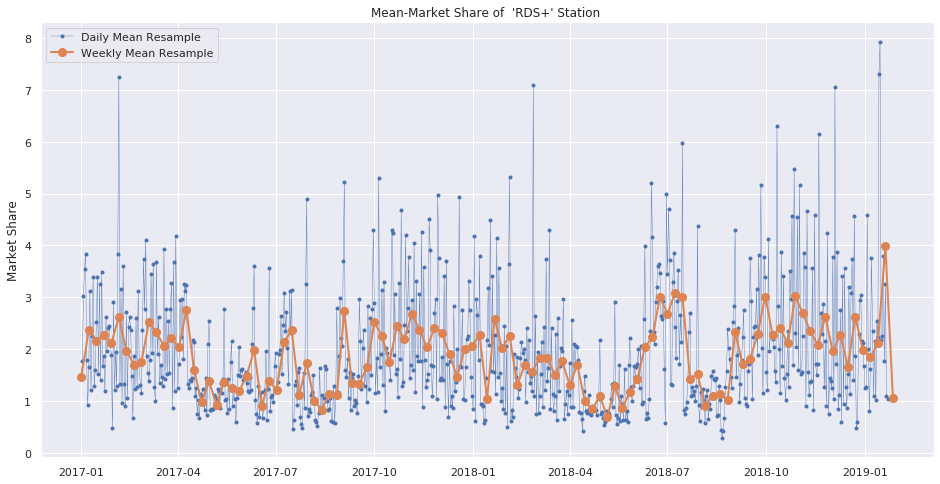

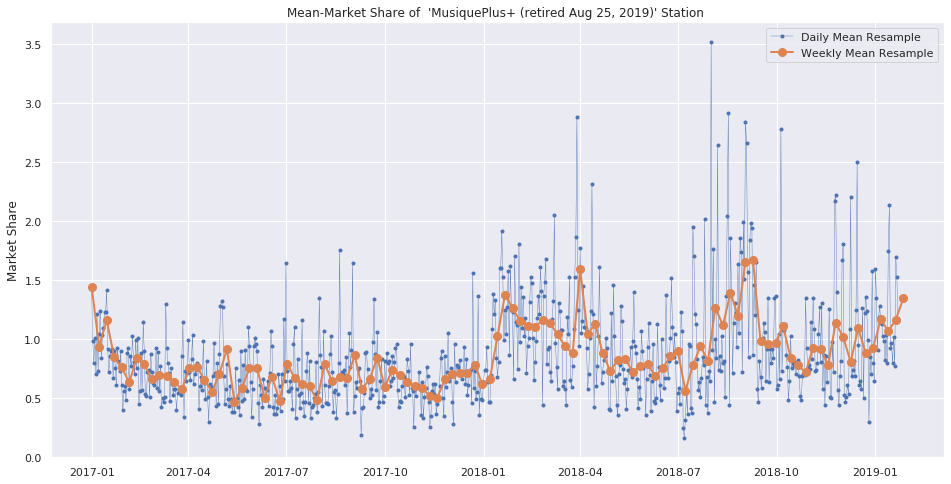

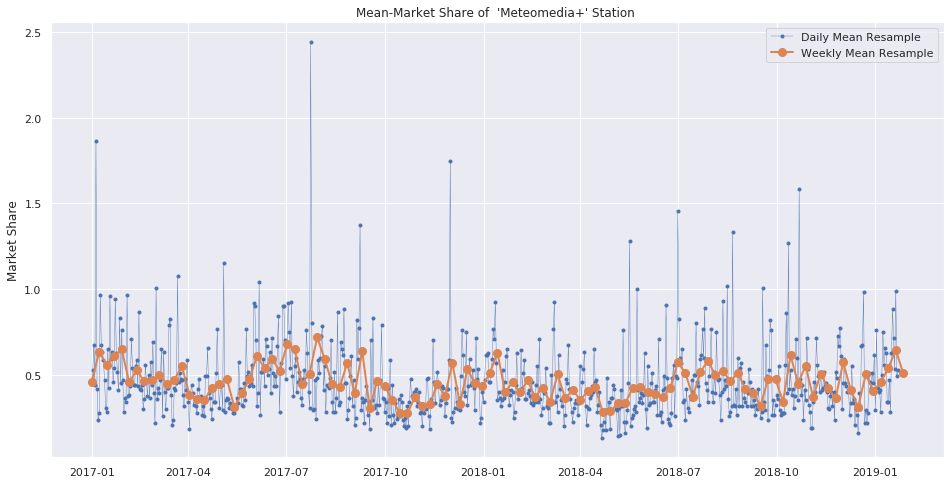

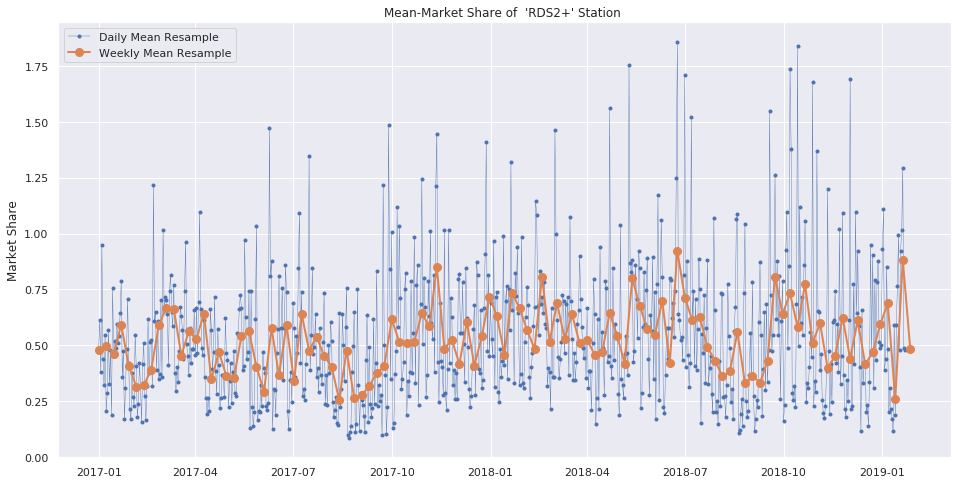

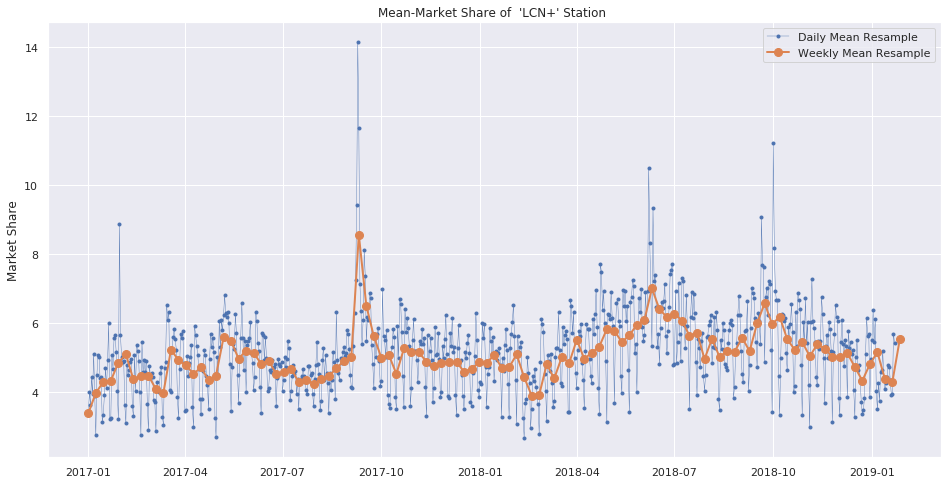

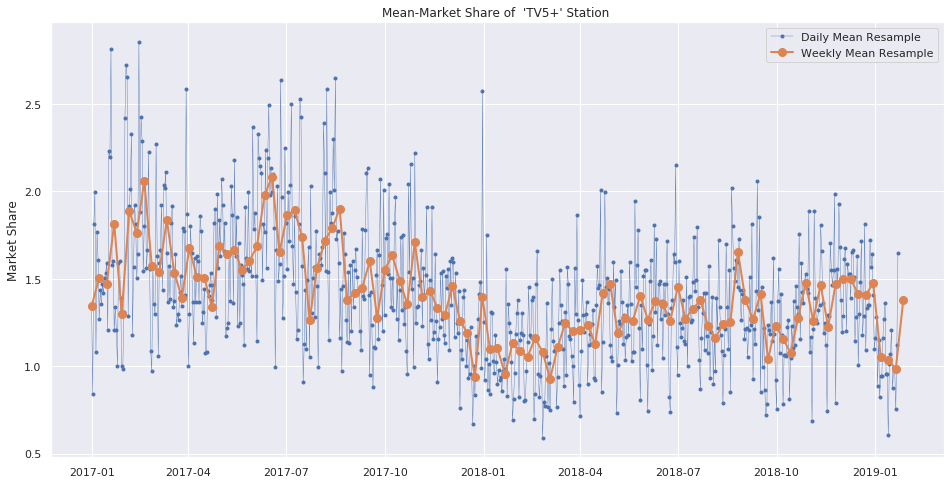

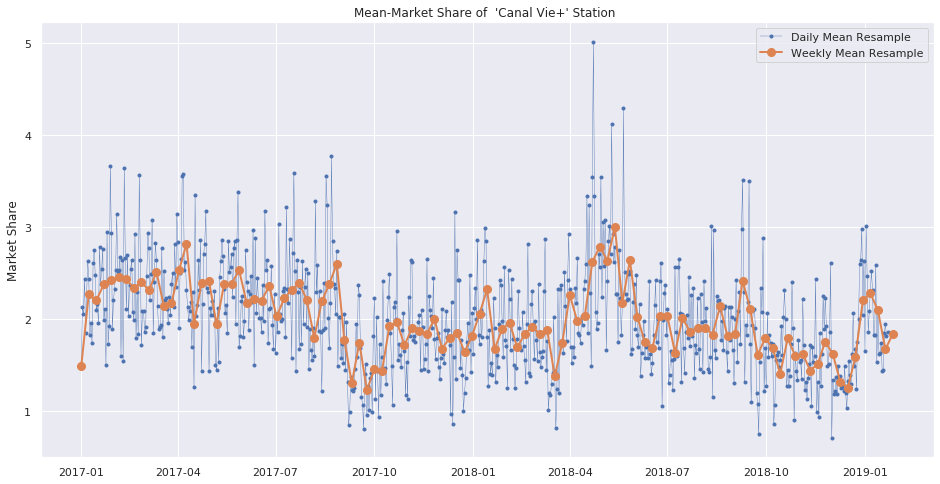

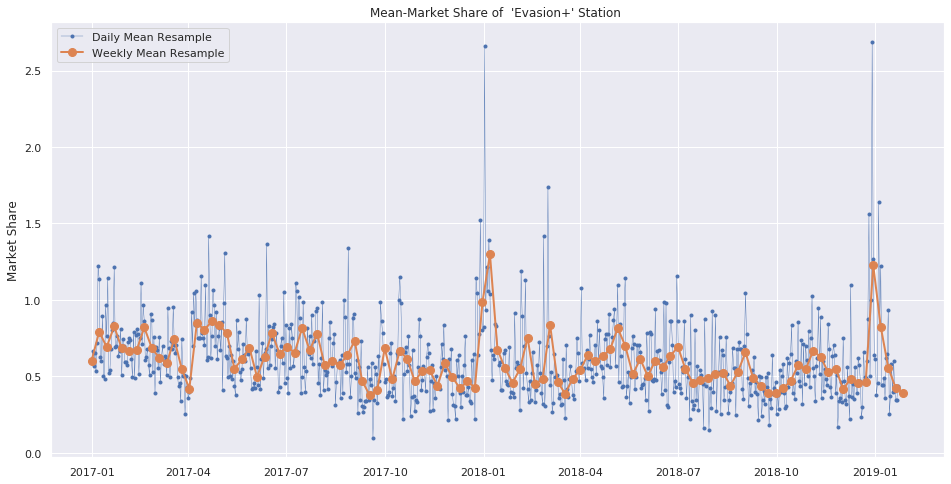

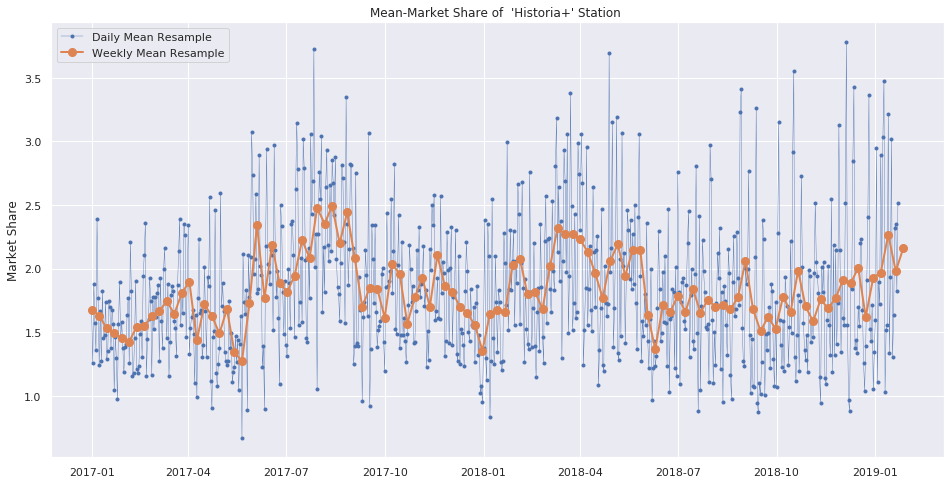

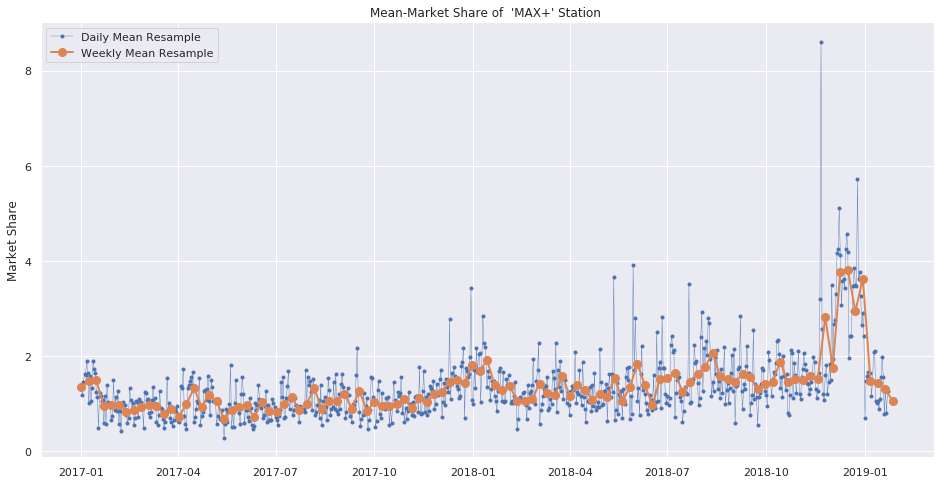

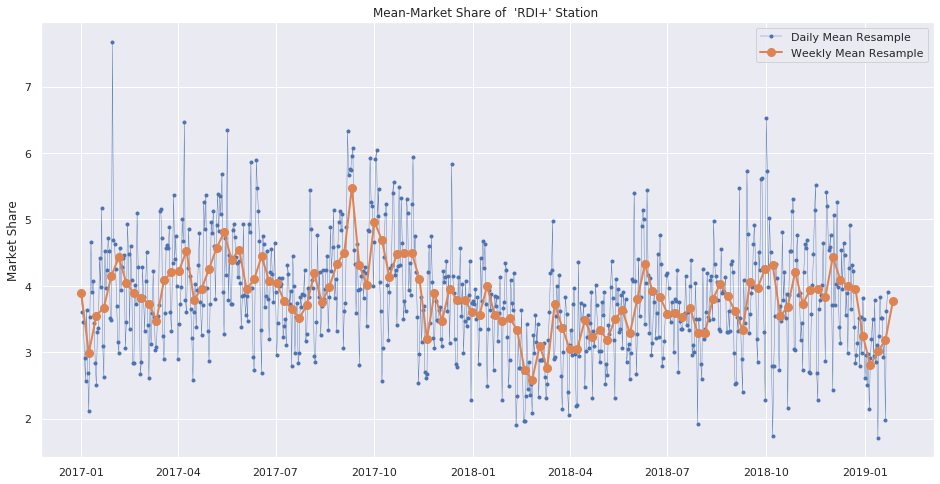

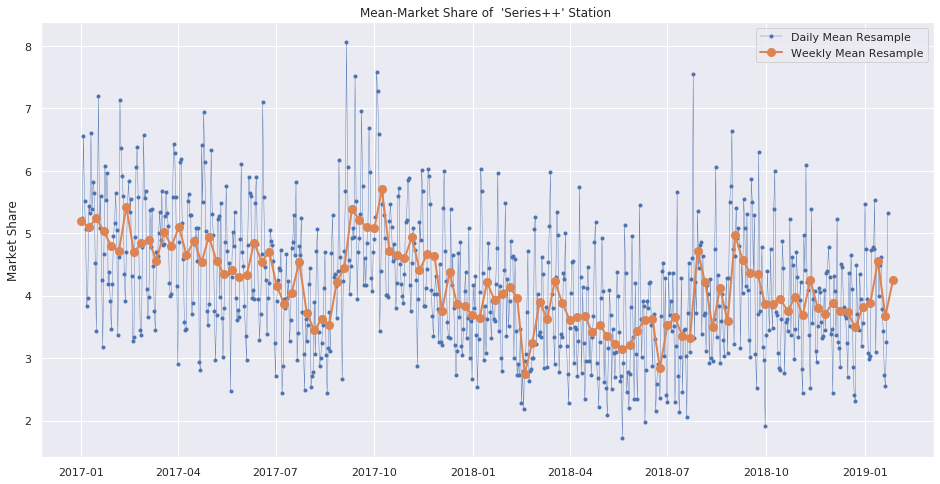

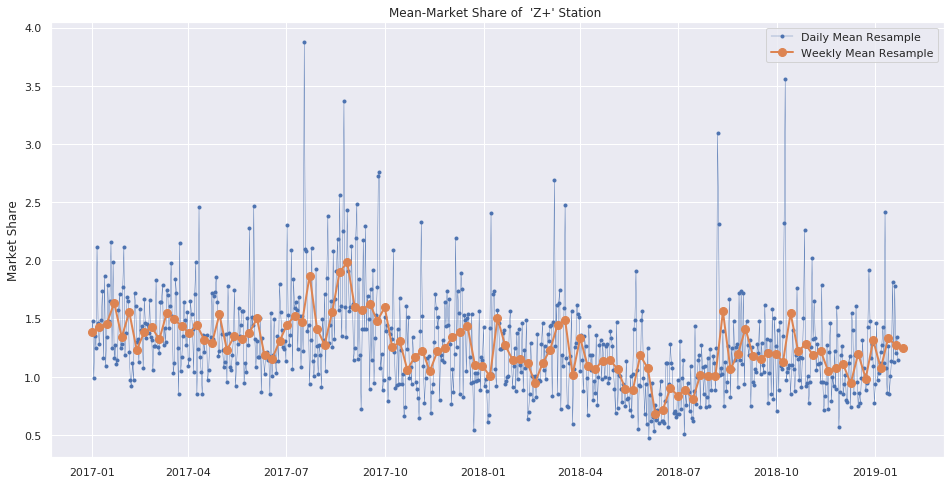

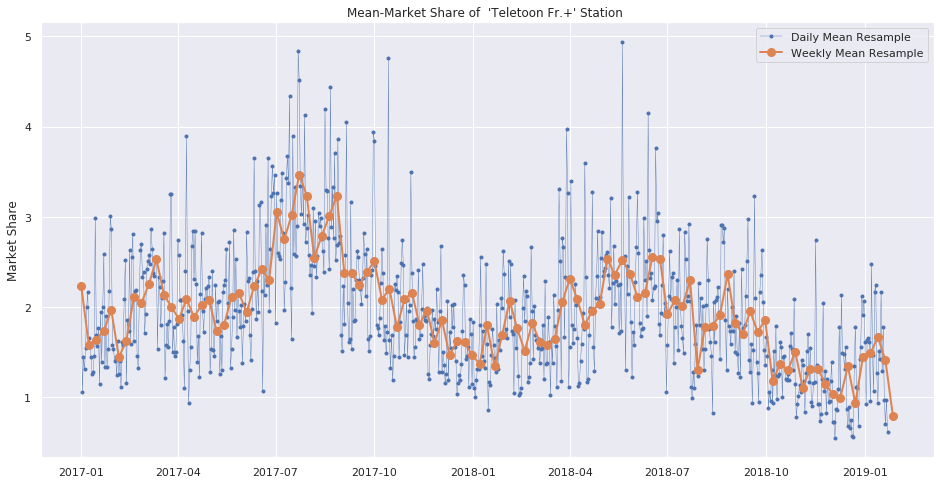

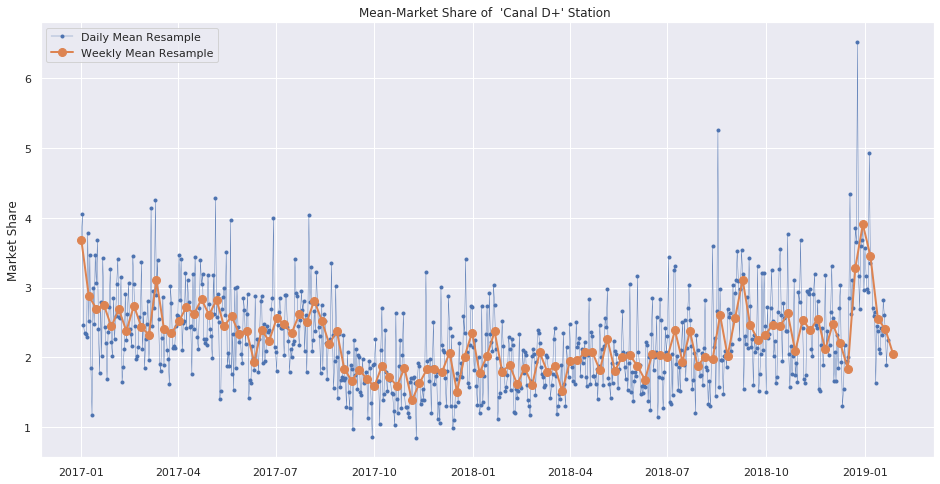

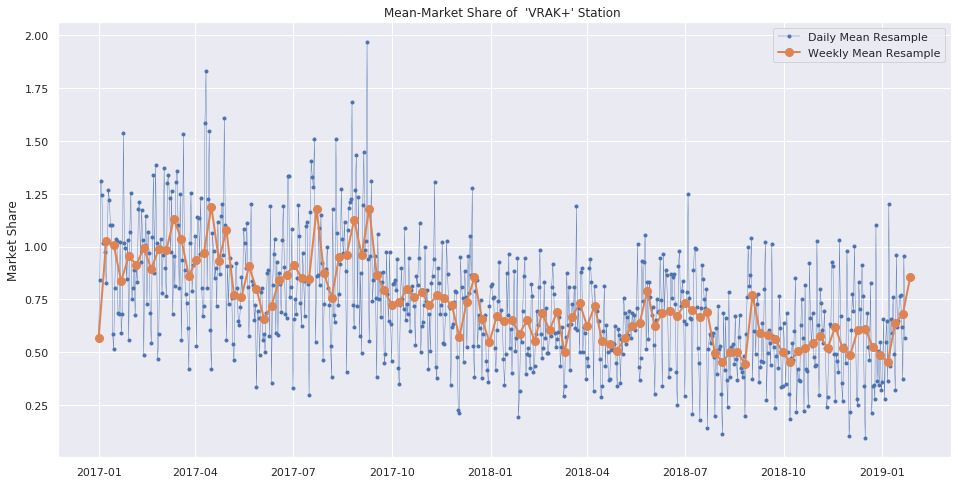

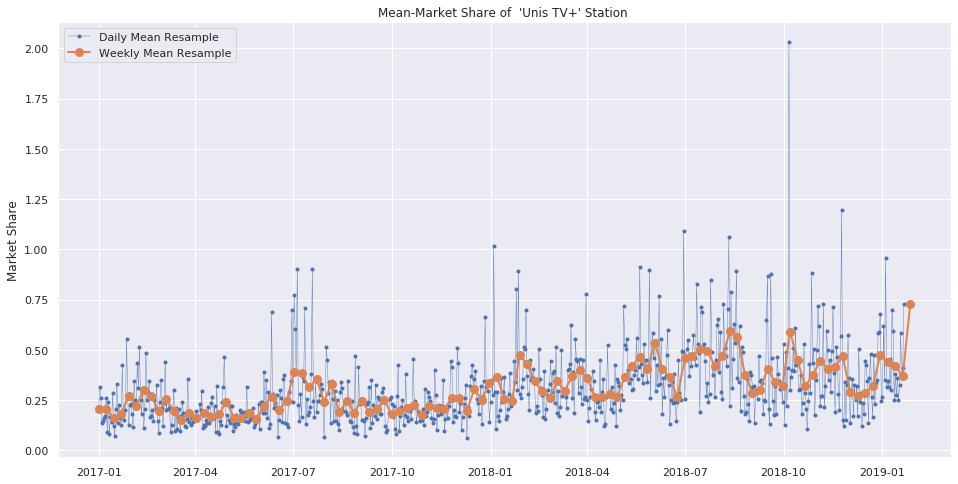

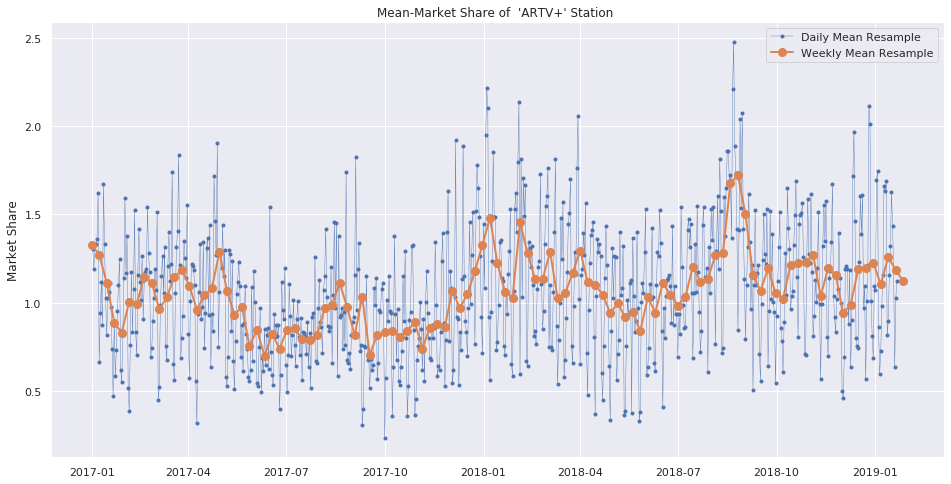

In [12]:
stations = df["Station"].unique()
for station in stations:
    report_DW(df,station,"2017", "2020-12")

In [13]:
df_t = pd.read_csv("test.csv")

df_t["Date"] = df_t["Date"].astype("datetime64[ns]")
df_t["Start_time"] = df_t["Start_time"].astype("datetime64[ns]")
df_t["End_time"] = df_t["End_time"].astype("datetime64[ns]")

df_t.drop(["Unnamed: 0","Episode","Year",'Day of week',"Name of show","Name of episode","Temperature in Montreal during episode",'# of episode in the season', 'Genre', 'First time or rerun','Movie?','Game of the Canadiens during episode?'],axis=1,inplace=True)


In [14]:
test_date = "2019-01-22"
df_t["Market Share_total"] = 0
df_total = df.append(df_t,ignore_index=True)

In [15]:
df_channels = []
for s in stations:
    temp =df_total[df_total["Station"]==s]
    df_channels.append(temp)

In [16]:
for i in range(len(df_channels)):
    df_channels[i].reset_index(inplace=True)


In [17]:
def convertor(dateT,length):
    if length > 0:
        tot = 15 * length 
        hour,  min_ = divmod(tot,60)
    else:
        hour = 0
        min_ = 1
    
    return dateT + timedelta(hour,min_)   

In [18]:
df_channels[1][df_channels[1]["Start_time"].isna()]

,index,Station,Channel Type,Season,Date,Start_time,End_time,Length,Market Share_total
7508,141230,SRC Total,0,Winter,2017-03-22,NaT,NaT,3,7.7
22560,397662,SRC Total,0,Winter,2018-03-22,NaT,NaT,5,11.1
40622,656950,SRC Total,General Channel,Winter,2019-03-22,NaT,NaT,4,0.0


In [19]:
# to fill null value
for i in range(len(df_channels)):
    for index, row in df_channels[i][df_channels[i]["Start_time"].isna()].iterrows():
        past_index = index-1
        le = row["Length"]
        dt = df_channels[i].loc[past_index]["End_time"]
        End_time = convertor(dt,le)
        df_channels[i].loc[index,"Start_time"] = dt
        df_channels[i].loc[index,"End_time"] = End_time

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [20]:
for i in range(len(df_channels)):
    a = df_channels[i][df_channels[i]["Start_time"].isna()]
    print(len(a))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [21]:
def channel_prepare(channel):

    temp_df = channel[["Start_time","Market Share_total"]].copy()
    temp_df.set_index("Start_time",drop=True,inplace=True)
    div = channel[channel["Date"]=="2019-01-23"].index[0]
    
    
    temp_series = temp_df["Market Share_total"]
    array = temp_series.values.reshape(temp_series.shape[0],1)
    
    scl = MinMaxScaler()
    array =  scl.fit_transform(array)
    
    array_train = array[:div]
    array_test = array[div-look_back:]
    return array_train, array_test
    
def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)


def processData(data, look_back, forward_days,jump=1):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        X.append(data[i:(i+look_back)])
        Y.append(data[(i+look_back):(i+look_back+forward_days)])
    return np.array(X),np.array(Y)

In [22]:
look_back = 100
forward_days = 50
num_periods = 100
# this segement just for one channel! but easly we can put it in "for" for other channel
array_train, array_test = channel_prepare(channel = df_channels[15])

X_test,y_test = processData(array_test,look_back,forward_days,forward_days)
y_test = np.array([list(a.ravel()) for a in y_test])

X,y = processData(array_train,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])

from sklearn.model_selection import train_test_split
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, shuffle=False)

In [23]:
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 5

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=2)

Train on 17140 samples, validate on 4286 samples
Epoch 1/5


KeyboardInterrupt: 